## Training Script

#### Importing Libraries



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from tqdm import tqdm
from matplotlib import pyplot as plt

#### Dataset

In [2]:
class DigitSumDataset(Dataset):
    def __init__(self, image_path, label_path):
        self.images = np.load(image_path)
        self.labels = np.load(label_path)
        self.images = torch.tensor(self.images, dtype=torch.float32) / 255.0
        self.labels = torch.tensor(self.labels, dtype=torch.float32)
        self.images = self.images.unsqueeze(1)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

#### Model

In [3]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()

        # Load pre-trained ResNet50 and modify the first convolution to accept 1 channel (grayscale) [normal model accepts 3]
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to output 128 features
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            torch.nn.Linear(num_features, 128),
            torch.nn.ReLU()  # Add ReLU activation
        )

        # Final layer to output a single value for regression
        self.fc = nn.Sequential(
            torch.nn.Linear(128, 1)  # Single output for sum of digits
        )

    def forward(self, x):
        # Forward pass through the modified ResNet and final fully connected layer
        x = self.resnet(x)
        x = self.fc(x)
        return x


#### Loading train, validation and test datasets


In [4]:
train_img_path = 'DL-Project/data0.npy'
train_label_path = 'DL-Project/lab0.npy'

val_img_path = 'DL-Project/data1.npy'
val_label_path = 'DL-Project/lab1.npy'

test_img_path = 'DL-Project/data2.npy'
test_label_path = 'DL-Project/lab2.npy'

train_dataset = DigitSumDataset(train_img_path, train_label_path)
val_dataset = DigitSumDataset(val_img_path, val_label_path)
test_dataset = DigitSumDataset(test_img_path, test_label_path)

##### Creating data loaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Training

In [ ]:
img_model = ResNetModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(img_model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for epoch in range(10):
    img_model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # Add a channel dimension to the images (since they are grayscale and the model expects 1 channel)
        images = images.to(device)
        labels = labels.to(device)

        # print(images.shape)
        
        optimizer.zero_grad()
        outputs = img_model(images)
        #  Remove the extra dimension added by the model's output (the output is [batch_size, 1], but labels are [batch_size])
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    img_model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = img_model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # save best model
    if val_losses[-1] == min(val_losses):
        torch.save(img_model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch} val loss: {val_loss / len(val_loader)}')

100%|██████████| 313/313 [01:19<00:00,  3.93it/s]


Epoch 0 val loss: 5.549208466237346


100%|██████████| 313/313 [01:19<00:00,  3.93it/s]


Epoch 1 val loss: 8.802883034696976


100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 2 val loss: 3.707468127671141


100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch 3 val loss: 3.352711346202765


100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch 4 val loss: 2.105498818543772


100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 5 val loss: 1.9187443074517356


100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 6 val loss: 1.8472951003156912


100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 7 val loss: 3.9563389384327605


100%|██████████| 313/313 [01:19<00:00,  3.95it/s]


Epoch 8 val loss: 1.6080054054245019


100%|██████████| 313/313 [01:18<00:00,  3.98it/s]

Epoch 9 val loss: 1.7663549181942741


##### Loss Graph

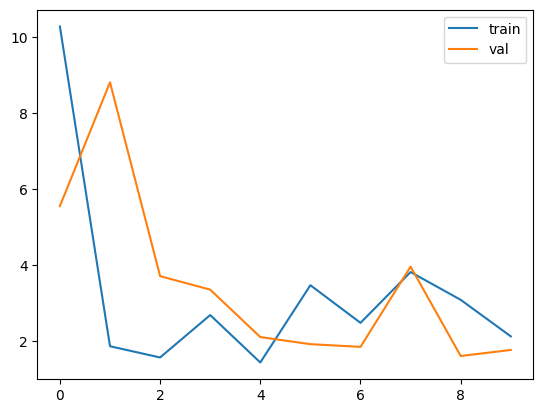

In [8]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()